In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from fastai import *
from fastai.text import *

In [4]:
np.random.seed(20180125)

# Python code Examples (testing out tokenizer)

## Data

### Reading the texts

In [5]:
PATH = Path('/home/farzin/rnn_python_code/wiki103_from_download')/'etoe'

In [6]:
all_texts_df = pd.read_csv('/home/farzin/fast_ai/fastai_v1/courses/dl2/imdb_scripts/data/wiki/en/train.csv',sep='%$#')

/home/farzin/anaconda3/envs/fastaiv1_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [7]:
all_texts = all_texts_df.values.squeeze()

In [8]:
idx = np.random.permutation(len(all_texts))
cut = int(0.1 * len(idx))
train_df = pd.DataFrame({'text':all_texts[idx[cut:]], 'labels':[0] * (len(all_texts)-cut)}, columns=['labels','text'])
valid_df = pd.DataFrame({'text':all_texts[idx[:cut]], 'labels':[0] * cut}, columns=['labels','text'])

In [9]:
#export
def sub_br(t:str) -> str:
    "Replaces the <br /> by \n"
    re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
    return re_br.sub("\n", t)

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, rm_useless_spaces, sub_br]
default_spec_tok = [BOS, FLD, UNK, PAD]

In [10]:
tokenizer = Tokenizer(pre_rules=default_rules, special_cases=[BOS, FLD, 'xxunk', 'xxpad'], n_cpus=4)
tokenizer

Tokenizer SpacyTokenizer in en with the following rules:
 - fixup
 - replace_rep
 - replace_wrep
 - deal_caps
 - spec_add_spaces
 - rm_useless_spaces
 - sub_br
 - replace_all_caps
 - deal_caps

In [11]:
train_df = train_df.dropna().head(10000)
valid_df = valid_df.dropna()

In [12]:
max_vocab = 60000 #can we make this the full possible vocab at 260k?
batch_size = 32

keyword_args = {'max_vocab':max_vocab,'bs':batch_size}
data = TextLMDataBunch.from_df(PATH, train_df, valid_df, tokenizer=tokenizer,
                               text_cols='text', label_cols='labels',**keyword_args)

In [13]:
len(data.vocab.itos)

12564

In [14]:
data.save('tmp_etoe_demo')

In [15]:
!ls -lhart {PATH}/tmp_etoe_demo/

total 125M
drwxrwxr-x 3 farzin farzin 4.0K Jan 25 13:27 ..
-rw-rw-r-- 1 farzin farzin 206K Jan 25 13:27 itos.pkl
-rw-rw-r-- 1 farzin farzin 4.3M Jan 25 13:27 train_ids.npy
-rw-rw-r-- 1 farzin farzin  79K Jan 25 13:27 train_lbl.npy
-rw-rw-r-- 1 farzin farzin 118M Jan 25 13:27 valid_ids.npy
-rw-rw-r-- 1 farzin farzin 2.2M Jan 25 13:27 valid_lbl.npy
-rw-rw-r-- 1 farzin farzin    2 Jan 25 13:27 classes.txt
drwxrwxr-x 2 farzin farzin 4.0K Jan 25 13:27 .


In [16]:
bptt = 140
emb_sz,nh,nl = 400,1111,4

learn = language_model_learner(data,bptt,emb_sz,nh,nl,drop_mult=0.5,qrnn=True)
learn.unfreeze()
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(12564, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(12564, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=800, out_features=3333, bias=True)
        )
      )
      (1): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=3333, bias=True)
        )
      )
      (2): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=3333, bias=True)
        )
      )
      (3): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1111, out_features=1200, bias=True)
        )
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
      (3): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Li

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


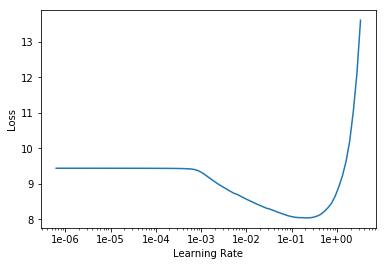

In [17]:
lr_find(learn)
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7), wd=0.03, pct_start=0.25)

epoch,train_loss,valid_loss,accuracy
1,6.147425,5.709587,0.155107
2,5.830985,5.525620,0.186684


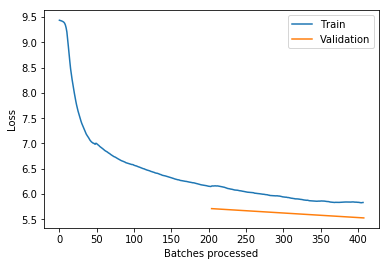

In [19]:
learn.recorder.plot_losses()

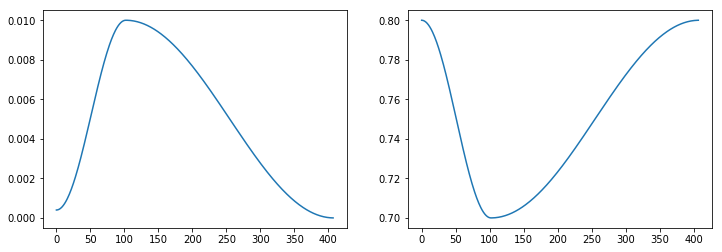

In [20]:
learn.recorder.plot_lr(show_moms=True)

In [21]:
learn.save("wiki103_raw_articles_spacy_20190125")

In [22]:
learn.save_encoder('wiki103_spacy_enc')